**LOAD DATA**

In [ ]:
import zipfile
import cv2
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
import pandas as pd
from numpy.ma.core import ravel
from PIL import Image
import io
from sklearn.metrics import accuracy_score
from io import BytesIO
import base64
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

drive.mount('/content/drive/', force_remount=True)


Mounted at /content/drive/


In [ ]:
import gzip
import pandas as pd
with gzip.open('/content/drive/My Drive/KDDCupData/corrected.gz','r') as corr:
    #pd = pd.read_csv(fin,header=0, usecols=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24'])
    corrected = pd.read_csv(corr, header=None)

with gzip.open('/content/drive/My Drive/KDDCupData/kddcup.data.gz','r') as kdd:
    #pd = pd.read_csv(fin,header=0, usecols=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24'])
    kddData = pd.read_csv(kdd, header=None)
    

In [ ]:
print(kddData)

         0    1     2   3    4      5   6   7   8   9   ...   32   33   34  \
0         0  tcp  http  SF  215  45076   0   0   0   0  ...    0  0.0  0.0   
1         0  tcp  http  SF  162   4528   0   0   0   0  ...    1  1.0  0.0   
2         0  tcp  http  SF  236   1228   0   0   0   0  ...    2  1.0  0.0   
3         0  tcp  http  SF  233   2032   0   0   0   0  ...    3  1.0  0.0   
4         0  tcp  http  SF  239    486   0   0   0   0  ...    4  1.0  0.0   
...      ..  ...   ...  ..  ...    ...  ..  ..  ..  ..  ...  ...  ...  ...   
4898426   0  tcp  http  SF  212   2288   0   0   0   0  ...  255  1.0  0.0   
4898427   0  tcp  http  SF  219    236   0   0   0   0  ...  255  1.0  0.0   
4898428   0  tcp  http  SF  218   3610   0   0   0   0  ...  255  1.0  0.0   
4898429   0  tcp  http  SF  219   1234   0   0   0   0  ...  255  1.0  0.0   
4898430   0  tcp  http  SF  219   1098   0   0   0   0  ...  255  1.0  0.0   

           35    36   37    38   39   40       41  
0        0.

In [ ]:
print(corrected)

In [ ]:
corrected.rename(columns = {'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'num_compromised', 'su_attempted', 'num_root', 'num_file_creations', 'label'}
, inplace = True)
kddData.rename(columns = {'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'num_compromised', 'su_attempted', 'num_root', 'num_file_creations', 'label'}
, inplace = True)


In [ ]:
result = (kddData.dtypes)
i = 0;
print(result)
dum1 = pd.get_dummies(kddData[1])
dum2 = pd.get_dummies(kddData[2])
dum3 = pd.get_dummies(kddData[3])
dum4 = pd.get_dummies(kddData[41])

kddData = kddData.drop(kddData.columns[1], axis='columns')
kddData = kddData.drop(kddData.columns[2], axis='columns')
kddData = kddData.drop(kddData.columns[3], axis='columns')
kddData = kddData.drop(kddData.columns[41], axis='columns')

print(dum1)
print("\n")
print(dum2)
print("\n")
print(dum3)
print("\n")
print(dum4)
# get the dummies and store it in a variable

 
# Concatenate the dummies to original dataframe

# drop the values

print(kddData)
# print the dataframe

In [ ]:
print(corrected[1])
df1 = pd.get_dummies(corrected[1])
print(df1)

**Laod data file from drive then Convert every image into a vector of 10304 values corresponding to the 
image size**

In [ ]:
def read_dataset():
  faces = {}
  with zipfile.ZipFile(r"/content/drive/My Drive/Data/archive.zip") as facezip:
      # facezip.printdir()
      # print(facezip.namelist())
      for filename in facezip.namelist():
          if not filename.endswith(".pgm"):
              continue  # not a face picture
          with facezip.open(filename) as image:
              # If we extracted files from zip, we can use cv2.imread(filename) instead
              faces[filename] = cv2.imdecode(np.frombuffer(image.read(), np.uint8), cv2.IMREAD_GRAYSCALE)
  return faces

**Convert every image into a vector of 10304 values corresponding to the 
image size**

In [ ]:
def getDataValues(faces):
  DataValues = []
  flag = 1
  for key, value in faces.items():
      temp = value.flatten()
      if (flag == 1):
        flag = 0
        DataValues = temp
        continue
      DataValues = np.vstack((DataValues, temp))

  DataValues = pd.DataFrame(DataValues)
  return DataValues

**Stack the 400 vectors into a single Data Matrix D and generate the label 
vector y. The labels are integers from 1:40 corresponding to the subject 
id.**

In [ ]:
def getDataWithLabels(faces):
  D = []
  flag = 1
  for key, value in faces.items():
      temp = value.flatten()
      temp = np.append(temp, key.partition("/")[0].replace("s", ''))
      if (flag == 1):
        flag = 0
        D = temp
        continue
      D = np.vstack((D, temp))
  DataMatrix = pd.DataFrame(D)
  DataMatrix.rename(columns={10304:'Y'}, inplace=True)
  return DataMatrix

**keep the odd rows for training and 
the even rows for testing and Split the labels vector accordingly**

In [ ]:
def splitData(DataValues, DataMatrix):
  trainingData = DataValues.iloc[::2]
  trainingData = trainingData.reset_index(drop = True)
  training_data_labels = DataMatrix['Y'].iloc[::2]
  training_data_labels = training_data_labels.reset_index(drop = True)
  testingData = DataValues.iloc[1::2]
  testingData = testingData.reset_index(drop = True)
  testing_data_labels = DataMatrix['Y'].iloc[1::2]
  testing_data_labels = testing_data_labels.reset_index(drop = True)
  return trainingData, testingData, training_data_labels, testing_data_labels

**Get dimensionality**

In [ ]:
#choose dimensionality
def getDimensionality(alpgha, w):
  sumEignvalues = np.sum(w)
  s = 0
  r = 0
  for eigvalue in w:
    r = r + 1
    s = s + eigvalue
    if (s / sumEignvalues) >= alpgha:
      break
  return r

**Get eigenfaces**

In [ ]:
def getEigenfaces(r, v):
  U = []
  q = v.T;
  U = q[0]
  for i in range(1, r):
    U = np.vstack((U, q[i]))
  return U

**Compute eigenvalues and eigenvectors**

In [ ]:
def getEigenValuesAndVectors(trainingData):
  #compute mean of training data
  data_mean = np.mean(trainingData)
  #center data
  z = trainingData.apply(lambda x: x-x.mean())  
  # compute covariance matrix
  cov_matrix = (1/len(trainingData)) * np.dot(np.transpose(z), z)
  # get eigenvalues and eigenvectors
  w, v = np.linalg.eig(cov_matrix)
  return w, v

**PCA**

In [ ]:
def PCA(trainingData, testingData, eigenvalues, eigenvectors, alpha):
  #compute mean of training data
  data_mean = np.mean(trainingData)
  #center data
  z = trainingData.apply(lambda x: x-x.mean())  
  # compute covariance matrix
  #sort eigenvectors corresponding to eigen values
  idx = eigenvalues.argsort()[::-1]   
  w = eigenvalues[idx]
  v = eigenvectors[:,idx]
  #choose dimensionality
  r = getDimensionality(alpha, w)
  #get eigenfaces
  eigenfaces = getEigenfaces(r, v)
  data_mean = np.array(data_mean).reshape(1, 10304)
  #Project the training set
  new_training_data = eigenfaces @ (z).T
  #Project the testing set
  normalized_testing_data = testingData - data_mean
  new_testing_data = eigenfaces @ (normalized_testing_data).T

  return new_training_data, new_testing_data, r

In [ ]:
faces = read_dataset()
DataMatrix = getDataWithLabels(faces)
DataValues = getDataValues(faces)
trainingData, testingData, training_data_labels, testing_data_labels = splitData(DataValues, DataMatrix)
eigenvalues, eigenvectors = getEigenValuesAndVectors(trainingData)

**Use a simple classifier (first Nearest Neighbor to determine the class 
labels)**

In [ ]:
alpha = [0.2,0.5,0.7,0.8, 0.85, 0.9, 0.95]
labels = []
count_mismatched = 0;

# accuracy_matrix contain accuracy for each value of alpha
accuracy_matrix = []
for alp in alpha:
  new_training_data, new_testing_data, r = PCA(trainingData, testingData, eigenvalues, eigenvectors, alp)
  for s in range (0, 200):
    query_weight = np.array(new_testing_data[s]).reshape(r, 1)
    euclidean_distance = np.linalg.norm(new_training_data - query_weight, axis=0)
    best_match = np.argmin(euclidean_distance)
    labels.append(training_data_labels[best_match])
    if (training_data_labels[best_match] != testing_data_labels[s]):
      count_mismatched +=1
    # fig, axes = plt.subplots(1,2,sharex=True,sharey=True,figsize=(8,6))
    # axes[0].imshow(np.reshape(np.ravel(testingData.T[s]), (112, 92)), cmap="gray")
    # axes[0].set_title("Query")
    # axes[1].imshow(np.reshape(np.ravel(trainingData.T[best_match]), (112, 92)), cmap="gray")
    # axes[1].set_title("Best match")
    # plt.show()
  accuracy = ((200 - count_mismatched) * 100)  / (200)
  accuracy_matrix.append(accuracy)
  count_mismatched = 0
  labels.clear()
print("accuracy matrix: ", accuracy_matrix)
print("alpha: ", alpha)
plt.plot(alpha, accuracy_matrix)
plt.xlabel("alpha")
plt.ylabel("accuracy")

# 5. LDA

### get the data and split it

In [ ]:
DataMatrix = DataMatrix.astype(int)

In [ ]:
DataMatrix['Y'].unique()

array([ 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29,  3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,  4,
       40,  5,  6,  7,  8,  9])

In [ ]:
# we need supervised data to apply LDA so we get the train & test data with labels
train_data = DataMatrix.iloc[0::2].reset_index().drop(columns = ['index'])
train_data.head()

,0,1,2,3,4,5,6,7,8,9,...,10295,10296,10297,10298,10299,10300,10301,10302,10303,Y
0,48,49,45,47,49,57,39,42,53,49,...,44,40,41,49,42,44,47,46,46,1
1,60,60,62,53,48,51,61,60,71,68,...,35,28,33,31,31,37,32,34,34,1
2,63,53,35,36,33,34,31,35,39,43,...,169,166,161,158,169,137,41,10,24,1
3,43,50,41,58,78,83,67,48,44,46,...,164,164,162,159,156,155,158,153,169,1
4,44,43,32,32,30,30,38,40,48,66,...,42,42,40,33,29,37,43,43,37,1


In [ ]:
test_data = DataMatrix.iloc[1::2].reset_index().drop(columns = ['index'])
test_data.head()

,0,1,2,3,4,5,6,7,8,9,...,10295,10296,10297,10298,10299,10300,10301,10302,10303,Y
0,34,34,33,32,38,40,39,49,54,57,...,44,38,30,37,30,36,37,40,33,1
1,39,44,53,37,61,48,61,45,35,40,...,30,36,32,28,32,31,29,26,29,1
2,64,76,80,53,34,72,60,66,66,50,...,28,34,32,35,34,35,35,37,39,1
3,41,47,47,46,44,49,48,58,61,49,...,34,35,34,36,34,39,35,37,38,1
4,42,41,44,46,48,39,37,37,33,37,...,33,39,39,40,41,43,42,43,41,1


In [ ]:
train_data.shape #half of the data for train

(200, 10305)

In [ ]:
test_data.shape  # half of the data for test

(200, 10305)

In [ ]:
train_data[train_data['Y'] == 1]

,0,1,2,3,4,5,6,7,8,9,...,10295,10296,10297,10298,10299,10300,10301,10302,10303,Y
0,48,49,45,47,49,57,39,42,53,49,...,44,40,41,49,42,44,47,46,46,1
1,60,60,62,53,48,51,61,60,71,68,...,35,28,33,31,31,37,32,34,34,1
2,63,53,35,36,33,34,31,35,39,43,...,169,166,161,158,169,137,41,10,24,1
3,43,50,41,58,78,83,67,48,44,46,...,164,164,162,159,156,155,158,153,169,1
4,44,43,32,32,30,30,38,40,48,66,...,42,42,40,33,29,37,43,43,37,1


### calculate the mean vectors

In [ ]:
def calculate_class_mean(data):
  return data.groupby('Y').mean()

In [ ]:
def calculate_overall_mean(data):
  return data.mean()

In [ ]:
def calculate_meu_k_meu(mean_matrix, overall_mean):
  return mean_matrix - overall_mean

In [ ]:

def calculate_SB(centeralized_meu, data):  
  S_b = np.zeros((centeralized_meu.shape[1], centeralized_meu.shape[1]))
  values = list(centeralized_meu.index)
  for i in values:
    n_k = len(data[data['Y'] == i])
    S_i = np.dot(centeralized_meu.iloc[[i-1]].T, centeralized_meu.iloc[[i-1]])
    S_b += S_i * n_k
  
  return S_b

In [ ]:
def calculate_S(data, mean):
  S = np.zeros((data.shape[1]-1, data.shape[1]-1))
  values = sorted(data['Y'].unique())
  print(values)
  for c in values:
      Di = data[data['Y'] == c].drop(columns = ['Y']).to_numpy()
      Mui = np.mean(Di, axis=0)
      Zi = Di - np.transpose(Mui)
      Si = np.dot(np.transpose(Zi), Zi)
      S += Si 

  return S


In [ ]:
def last_matrix(Sb, S):
  return np.dot(np.linalg.inv(S),Sb)

In [ ]:
def get_dominant_eigenvectors(last):
  values, vectors = np.linalg.eigh(last)
  vectors = np.transpose(vectors)
  # sort in decreasing order
  idxs = np.argsort(abs(values))[::-1]
  values = values[idxs]
  vectors = vectors[idxs]
  # return the first n eigenVectors in our case we need the 39th dominant eigenVectors
  return vectors[0 : 39]

In [ ]:
def project_matrix(data, transform_matrix):
  return np.dot(data, np.transpose(transform_matrix))

In [ ]:
mean_matrix = calculate_class_mean(train_data)
mean_matrix

,0,1,2,3,4,5,6,7,8,9,...,10294,10295,10296,10297,10298,10299,10300,10301,10302,10303
Y,,,,,,,,,,,,,,,,,,,,,
1,51.6,51.0,43.0,45.2,47.6,51.0,47.2,45.0,51.0,54.4,...,88.6,90.8,88.0,87.4,86.0,85.4,82.0,64.2,57.2,62.0
2,34.8,36.2,35.4,37.4,34.8,37.4,36.4,36.2,36.6,37.4,...,67.4,80.2,69.0,84.4,77.0,78.0,66.2,73.6,72.4,73.6
3,105.0,103.2,107.6,105.2,106.0,106.6,107.4,106.8,106.4,108.8,...,42.8,45.4,41.0,47.6,43.4,46.2,47.0,47.4,44.8,46.8
4,117.8,116.6,117.0,117.4,118.2,116.8,117.0,119.6,117.2,117.6,...,51.4,65.4,64.8,60.8,68.0,67.2,63.4,67.0,64.4,63.8
5,130.6,130.4,129.0,129.6,129.2,130.2,130.6,129.4,129.2,129.4,...,64.0,67.6,66.8,66.2,65.4,67.2,63.8,66.4,63.6,67.4
6,150.6,150.8,149.8,152.8,149.2,153.0,150.2,151.0,152.0,150.6,...,119.0,116.4,113.0,106.8,102.0,99.6,97.6,98.4,97.6,97.8
7,53.6,53.4,55.0,54.6,54.4,55.6,56.2,55.4,57.8,54.2,...,60.2,60.4,60.0,62.8,61.0,62.6,61.2,61.8,62.8,61.6
8,123.8,121.6,123.0,122.2,120.0,118.8,116.0,117.0,115.8,114.6,...,60.4,56.4,58.8,61.4,55.8,61.0,54.2,57.8,57.8,55.0
9,108.6,109.6,109.6,109.0,111.4,109.0,110.8,109.0,110.4,111.0,...,81.2,80.0,79.6,78.6,79.8,79.8,76.8,80.8,79.0,80.2


In [ ]:
overall_mean = calculate_overall_mean(train_data.drop(columns = 'Y'))
overall_mean

0        84.970
1        84.790
2        85.055
3        85.200
4        85.180
          ...  
10299    75.370
10300    75.665
10301    76.390
10302    73.815
10303    72.215
Length: 10304, dtype: float64

In [ ]:
centralized_meu = calculate_meu_k_meu(mean_matrix, overall_mean)
centralized_meu

,0,1,2,3,4,5,6,7,8,9,...,10294,10295,10296,10297,10298,10299,10300,10301,10302,10303
Y,,,,,,,,,,,,,,,,,,,,,
1,-33.37,-33.79,-42.055,-40.0,-37.58,-34.49,-37.95,-40.125,-34.205,-30.74,...,5.685,9.685,9.51,8.43,8.835,10.03,6.335,-12.19,-16.615,-10.215
2,-50.17,-48.59,-49.655,-47.8,-50.38,-48.09,-48.75,-48.925,-48.605,-47.74,...,-15.515,-0.915,-9.49,5.43,-0.165,2.63,-9.465,-2.79,-1.415,1.385
3,20.03,18.41,22.545,20.0,20.82,21.11,22.25,21.675,21.195,23.66,...,-40.115,-35.715,-37.49,-31.37,-33.765,-29.17,-28.665,-28.99,-29.015,-25.415
4,32.83,31.81,31.945,32.2,33.02,31.31,31.85,34.475,31.995,32.46,...,-31.515,-15.715,-13.69,-18.17,-9.165,-8.17,-12.265,-9.39,-9.415,-8.415
5,45.63,45.61,43.945,44.4,44.02,44.71,45.45,44.275,43.995,44.26,...,-18.915,-13.515,-11.69,-12.77,-11.765,-8.17,-11.865,-9.99,-10.215,-4.815
6,65.63,66.01,64.745,67.6,64.02,67.51,65.05,65.875,66.795,65.46,...,36.085,35.285,34.51,27.83,24.835,24.23,21.935,22.01,23.785,25.585
7,-31.37,-31.39,-30.055,-30.6,-30.78,-29.89,-28.95,-29.725,-27.405,-30.94,...,-22.715,-20.715,-18.49,-16.17,-16.165,-12.77,-14.465,-14.59,-11.015,-10.615
8,38.83,36.81,37.945,37.0,34.82,33.31,30.85,31.875,30.595,29.46,...,-22.515,-24.715,-19.69,-17.57,-21.365,-14.37,-21.465,-18.59,-16.015,-17.215
9,23.63,24.81,24.545,23.8,26.22,23.51,25.65,23.875,25.195,25.86,...,-1.715,-1.115,1.11,-0.37,2.635,4.43,1.135,4.41,5.185,7.985


In [ ]:
S_b = calculate_SB(centralized_meu, train_data)
S_b

array([[231615.82 , 228816.94 , 231111.73 , ..., -41390.46 , -19667.31 ,
         -7796.11 ],
       [228816.94 , 226547.58 , 228482.91 , ..., -39573.22 , -18219.37 ,
         -7079.97 ],
       [231111.73 , 228482.91 , 231351.995, ..., -39955.09 , -18238.365,
         -7093.165],
       ...,
       [-41390.46 , -39573.22 , -39955.09 , ..., 335064.38 , 304869.63 ,
        288210.43 ],
       [-19667.31 , -18219.37 , -18238.365, ..., 304869.63 , 292480.555,
        277844.955],
       [ -7796.11 ,  -7079.97 ,  -7093.165, ..., 288210.43 , 277844.955,
        272640.155]])

In [ ]:
pd.DataFrame(S_b)

,0,1,2,3,4,5,6,7,8,9,...,10294,10295,10296,10297,10298,10299,10300,10301,10302,10303
0,231615.82,228816.94,231111.730,229960.6,229796.48,228024.74,229322.30,230353.350,228305.830,225669.64,...,-66772.910,-46852.910,-30198.06,-35900.58,-35380.410,-39746.78,-45958.810,-41390.46,-19667.310,-7796.110
1,228816.94,226547.58,228482.910,227416.6,227309.36,225545.78,226796.10,227797.650,225721.010,223065.88,...,-63964.970,-44363.170,-27794.22,-33274.06,-32761.070,-37184.06,-43854.870,-39573.22,-18219.370,-7079.970
2,231111.73,228482.91,231351.995,229875.8,229658.82,227744.61,229274.35,230329.625,228047.545,225232.66,...,-64559.265,-44721.265,-27976.39,-33415.07,-33259.615,-38125.67,-44608.515,-39955.09,-18238.365,-7093.165
3,229960.60,227416.60,229875.800,228988.4,228513.00,226651.20,228069.00,229072.400,226978.200,224264.40,...,-64316.000,-45619.800,-29120.80,-33892.60,-33687.200,-38236.80,-45640.400,-41543.80,-19871.600,-8368.000
4,229796.48,227309.36,229658.820,228513.0,228487.92,226492.36,228020.00,228986.900,226883.420,224134.36,...,-64992.940,-46056.340,-29440.44,-35134.12,-34760.740,-39335.52,-46069.340,-41819.24,-19748.340,-8302.140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10299,-39746.78,-37184.06,-38125.670,-38236.8,-39335.52,-39275.86,-40680.70,-38901.250,-40267.770,-41926.36,...,247814.690,251733.290,255646.14,265134.02,277127.990,269237.82,275377.190,270193.54,243228.490,237691.490
10300,-45958.81,-43854.87,-44608.515,-45640.4,-46069.34,-45208.97,-46821.55,-43924.625,-45946.865,-47405.82,...,247019.505,260584.505,260783.83,263802.79,278294.455,275377.19,299519.755,305296.73,275354.805,265391.405
10301,-41390.46,-39573.22,-39955.090,-41543.8,-41819.24,-41169.82,-42872.90,-38004.950,-42059.590,-43921.12,...,213262.630,244764.230,252004.18,255452.14,273921.130,270193.54,305296.730,335064.38,304869.630,288210.430
10302,-19667.31,-18219.37,-18238.365,-19871.6,-19748.34,-19374.07,-20060.05,-15265.375,-19474.215,-22020.02,...,179415.855,218769.855,232993.53,234640.49,247433.505,243228.49,275354.805,304869.63,292480.555,277844.955


In [ ]:
S = calculate_S(train_data, mean_matrix)
S

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]


array([[ 26322. ,  24844.8,  24771.6, ...,   -757.2,  -2197.8,   3702.4],
       [ 24844.8,  25913.6,  24942.4, ...,    190.6,   -395.4,   4566. ],
       [ 24771.6,  24942.4,  25832.4, ...,   -331.2,    332.4,   6442.8],
       ...,
       [  -757.2,    190.6,   -331.2, ..., 143575.2,  90017.8,  74673.8],
       [ -2197.8,   -395.4,    332.4, ...,  90017.8,  96311.6,  82691. ],
       [  3702.4,   4566. ,   6442.8, ...,  74673.8,  82691. ,  95567.6]])

In [ ]:
last = last_matrix(S_b, S)

In [ ]:
pd.DataFrame(last)

,0,1,2,3,4,5,6,7,8,9,...,10294,10295,10296,10297,10298,10299,10300,10301,10302,10303
0,3.043412e+15,2.430432e+15,3.399259e+15,3.218522e+15,2.713430e+15,3.246342e+15,3.196704e+15,4.924257e+15,3.922223e+15,2.995179e+15,...,-2.306136e+16,-1.837333e+16,-1.523978e+16,-2.074531e+16,-2.089575e+16,-2.689823e+16,-2.553639e+16,-2.036247e+16,-1.965988e+16,-1.784865e+16
1,6.127282e+15,5.984861e+15,5.319144e+15,5.458589e+15,6.049209e+15,5.499816e+15,5.461096e+15,4.119302e+15,5.104945e+15,5.741015e+15,...,1.441708e+16,8.035094e+15,5.010896e+15,6.943520e+15,7.897994e+15,1.503752e+16,1.633191e+16,1.219989e+16,1.210896e+16,1.168866e+16
2,3.677417e+15,3.818955e+15,3.145319e+15,3.102859e+15,3.874624e+15,3.633570e+15,3.852678e+15,3.263349e+15,4.034820e+15,4.027478e+15,...,2.977934e+15,1.231418e+15,-7.197599e+14,-3.504263e+15,-1.938409e+15,3.328741e+15,9.371335e+15,1.038072e+16,1.033949e+16,8.265365e+15
3,3.655612e+15,3.685808e+15,3.636630e+15,3.870535e+15,3.701595e+15,3.498255e+15,3.643864e+15,2.836221e+15,3.108640e+15,3.616134e+15,...,-1.747898e+16,-1.947031e+16,-2.066729e+16,-1.792456e+16,-1.863705e+16,-1.558227e+16,-1.604027e+16,-1.642714e+16,-1.582475e+16,-1.825867e+16
4,-1.381389e+15,-1.601526e+15,-1.107787e+15,-1.253516e+15,-1.507068e+15,-1.404441e+15,-1.236023e+15,-8.958749e+14,-1.646574e+15,-1.586346e+15,...,-1.093954e+16,-8.715052e+15,-7.356275e+15,-6.768365e+15,-7.378369e+15,-1.019064e+16,-1.212139e+16,-1.169033e+16,-1.125582e+16,-1.128969e+16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10299,-2.454895e+14,-2.584394e+14,-1.590234e+14,-1.899551e+14,-2.171761e+14,-2.348334e+14,-2.307549e+14,-8.650589e+13,-1.783818e+14,-2.595177e+14,...,-9.658575e+14,-7.386881e+14,-4.322039e+14,-6.369621e+14,-7.346637e+14,-1.465807e+15,-1.569268e+15,-1.139639e+15,-1.250668e+15,-1.116463e+15
10300,-1.635648e+15,-1.610533e+15,-1.657033e+15,-1.657941e+15,-1.606088e+15,-1.669047e+15,-1.710573e+15,-1.799228e+15,-1.638743e+15,-1.616724e+15,...,2.552482e+15,1.805117e+15,1.418274e+15,1.519941e+15,1.458409e+15,1.971885e+15,2.192792e+15,1.832596e+15,1.482413e+15,1.383727e+15
10301,-1.129552e+15,-1.128957e+15,-1.128167e+15,-1.153018e+15,-1.143564e+15,-1.120943e+15,-1.185735e+15,-1.123622e+15,-1.124376e+15,-1.143814e+15,...,2.921764e+15,2.684763e+15,2.366034e+15,2.144291e+15,2.184677e+15,2.089273e+15,2.296972e+15,2.126131e+15,1.703362e+15,1.811534e+15
10302,-1.729505e+15,-1.846492e+15,-1.429861e+15,-1.509273e+15,-1.770480e+15,-1.703301e+15,-1.593086e+15,-1.104814e+15,-1.632271e+15,-1.881512e+15,...,-1.055722e+16,-8.485528e+15,-6.753900e+15,-6.768611e+15,-7.038344e+15,-9.933198e+15,-1.102329e+16,-9.051361e+15,-8.838697e+15,-8.816605e+15


In [ ]:
dominant_vectors = get_dominant_eigenvectors(last)
dominant_vectors

array([[ 4.61472867e-04,  5.99339322e-04, -1.78662282e-05, ...,
         2.18662062e-03,  2.18639471e-02, -1.87759385e-04],
       [-4.40714559e-04, -5.80792260e-04,  4.24146546e-05, ...,
         2.20160237e-03,  2.18290118e-02, -1.72772394e-04],
       [ 9.45519479e-03,  9.35481932e-03,  9.30277938e-03, ...,
        -9.48475298e-03,  1.18968879e-02,  8.10270980e-04],
       ...,
       [ 1.48386104e-02,  1.52576765e-02,  1.31921393e-02, ...,
        -6.23740228e-03,  1.09386642e-02, -3.82606558e-03],
       [-8.12703879e-04, -1.16963608e-03, -9.78305841e-04, ...,
         1.47854088e-03, -6.11213394e-03,  6.45817232e-03],
       [-1.31867891e-02, -1.33183615e-02, -1.15272221e-02, ...,
         1.37486010e-03, -1.58978778e-02,  2.38050114e-03]])

In [ ]:
projected_data = project_matrix(train_data.drop(columns = ['Y']).to_numpy(), dominant_vectors)
projected_data

array([[ 3186.79723889, -3086.01327076,  5434.91897816, ...,
          594.04814368,  1520.27635624,  -328.93808066],
       [ 4391.01216859, -4310.37037892,  6063.72198657, ...,
          532.53689654,   997.57264087,  -302.64009498],
       [ 4365.90811366, -4265.11035885,  6173.81306048, ...,
          305.24573161,  1208.7291284 ,    87.44323866],
       ...,
       [ 2322.00921638, -2259.68106264,  4843.38075802, ...,
          404.49408   ,   726.70854912,  -172.07314936],
       [ 2310.11547689, -2260.1378238 ,  4745.8992767 , ...,
          450.95684121,   706.58569751,  -378.31756147],
       [ 2165.55609664, -2100.810541  ,  5214.33912116, ...,
          324.03424767,   872.98524434,  -248.34005774]])

In [ ]:
projected_data.shape

(200, 39)

In [ ]:
projected_test_data = project_matrix(test_data.drop(columns = ['Y']).to_numpy(), dominant_vectors)
projected_test_data

array([[ 3.70079661e+03, -3.67393852e+03,  6.13484125e+03, ...,
         6.37625108e+02,  9.18694924e+02, -2.87416029e+01],
       [ 3.97035959e+03, -3.92754278e+03,  5.92569437e+03, ...,
         6.77633948e+02,  1.58391997e+03, -4.28051987e+02],
       [ 4.40412050e+03, -4.35971441e+03,  6.54186178e+03, ...,
         5.19417016e+02,  9.02224428e+02, -4.99425358e+00],
       ...,
       [ 2.12572844e+03, -2.09780141e+03,  4.75789662e+03, ...,
         4.04396619e+02,  6.51434877e+02, -7.60473437e+01],
       [ 2.35452211e+03, -2.30585715e+03,  4.81856000e+03, ...,
         3.63199964e+02,  7.14591978e+02, -3.78035960e+02],
       [ 2.03224135e+03, -1.95371346e+03,  4.86833165e+03, ...,
         4.61003038e+02,  7.41462016e+02, -2.65996125e+02]])

In [ ]:
y_test = test_data['Y']

### KNN Model

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
X_train = projected_data
y_train = train_data['Y']

In [ ]:
model = KNeighborsClassifier(n_neighbors = 1)
model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [ ]:
pred = model.predict(projected_test_data)

In [ ]:
true = 0
false = 0

for i in range(200):
  if(pred[i] == y_test[i]):
    true += 1
  else:
    false += 1

print(f"true = {true}, false = {false}")


true = 190, false = 10


#Classifier Tuning

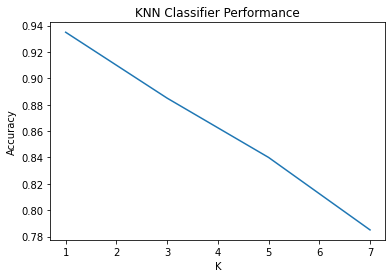

In [ ]:
#using KNN classifier with different values of k
k_values = [1, 3, 5, 7]
accuracies = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance', algorithm='auto', p=2, metric='minkowski')
    knn.fit(z, DataMatrix['Y'][::2])
    predictions = knn.predict(testingData - data_mean)
    accuracy = accuracy_score(DataMatrix['Y'][1::2], predictions)
    accuracies.append(accuracy)

#plotting accuracies against k
plt.plot(k_values, accuracies)
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title('KNN Classifier Performance')
plt.show()

In [ ]:
nonfaces = {}
with zipfile.ZipFile(r"/content/drive/My Drive/Data/Converted.zip") as nonfacezip:
      # facezip.printdir()
      # print(facezip.namelist())
      for filename in nonfacezip.namelist():
          if not filename.endswith(".pgm"):
              continue  # not a face picture
          with nonfacezip.open(filename) as image_file:
            image_data = BytesIO(image_file.read())
            # Open the image using Pillow
            image = Image.open(image_data)
            # Resize the image to 92x112 pixels
            resized_image = image.resize((92, 112))
            # Create a BytesIO object
            image_bytes = io.BytesIO()
            # Save the image data to the BytesIO object
            resized_image.save(image_bytes, format='JPEG')
            # If we extracted files from zip, we can use cv2.imread(filename) instead
            nonfaces[filename] = cv2.imdecode(np.frombuffer(image_bytes.getvalue(), np.uint8), cv2.IMREAD_GRAYSCALE)


In [ ]:
nonfaceDataValues = pd.DataFrame(np.reshape(np.ravel(list(nonfaces.values())), (843, 10304)))
nonfaceDataValues['Y'] = 2
print(nonfaceDataValues.head)

<bound method NDFrame.head of        0    1    2    3    4    5    6    7    8    9  ...  10295  10296  \
0     68   60   74   83   72   79   95   93   77   92  ...    118    179   
1     82   74   68   71   75   76   77   79   77   73  ...    114     71   
2     19   59   50   39   35   41   53   19   13    9  ...     17     19   
3     96   95   95   97  100  102  102  101  105  106  ...     99     99   
4    130  134  140  143  143  145  149  153  157  154  ...     78     79   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...    ...    ...   
838   15   15   15   15   15   15   15   15   15   15  ...     34     34   
839    0    0    0    0    0    1    3    3   12   15  ...     49     50   
840  226  252  185  113   84  109  241  240  148  119  ...     91     70   
841  165  168  167  165  171  183  187  185  181  189  ...    162    152   
842    8    8    9   12   16   18   18   16   19   18  ...     33     35   

     10297  10298  10299  10300  10301  10302  10303  Y  

In [ ]:
def LDA(train_data,test_data,dominant):
  mean_matrix = calculate_class_mean(train_data)
  overall_mean = calculate_overall_mean(train_data.drop(columns = 'Y'))
  centralized_meu = calculate_meu_k_meu(mean_matrix, overall_mean)
  S_b = calculate_SB(centralized_meu, train_data)
  pd.DataFrame(S_b)
  S = calculate_S(train_data, mean_matrix)
  last = last_matrix(S_b, S)
  pd.DataFrame(last)
  dominant_vectors = get_dominant_eigenvectors(last,dominant)
  projected_data = project_matrix(train_data.drop(columns = ['Y']).to_numpy(), dominant_vectors)
  projected_test_data = project_matrix(test_data.drop(columns = ['Y']).to_numpy(), dominant_vectors)
  y_test = test_data['Y']
  X_train = projected_data
  y_train = train_data['Y']
  model = KNeighborsClassifier(n_neighbors = 1)
  model.fit(X_train, y_train)
  pred = model.predict(projected_test_data)
  true = 0
  false = 0
  for i in range(pred.size):
    if(pred[i] == y_test[i]):
      true += 1
      print(f"Image {i}: SUCCESS (predicted {pred[i]}, actual {y_test[i]})")
    else:
      false += 1
      print(f"Image {i}: FAILURE (predicted {pred[i]}, actual {y_test[i]})")
  print(f"true = {true}, false = {false}")
  print(f"Accuracy = {str((true/(false+true)) *100)+'%'}")
  return (true/(false+true)) *100


In [ ]:
def get_dominant_eigenvectors(last,i):
  values, vectors = np.linalg.eigh(last)
  vectors = np.transpose(vectors)
  # sort in decreasing order
  idxs = np.argsort(abs(values))[::-1]
  values = values[idxs]
  vectors = vectors[idxs]
  # return the first n eigenVectors in our case we need the 39th dominant eigenVectors
  return vectors[0 : i]

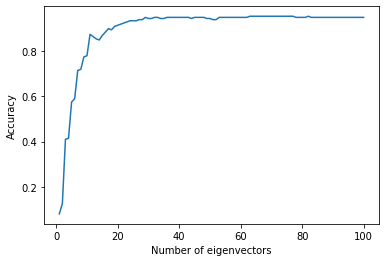

In [ ]:
accuracy = []
acc = 0
dominant = 0
dominantVec = get_dominant_eigenvectors(last, 101)  
for i in range(1, 101):
    dominant_vectors = dominantVec[0:i]
    train_temp = train_data.copy()
    test_temp = test_data.copy()
    projected_data = project_matrix(train_temp.drop(columns=['Y']).to_numpy(), dominant_vectors)
    projected_test_data = project_matrix(test_temp.drop(columns=['Y']).to_numpy(), dominant_vectors)
    model = KNeighborsClassifier(n_neighbors=1)
    model.fit(projected_data, train_temp['Y'])
    pred = model.predict(projected_test_data)
    y_te = train_temp['Y']
    accuracy.append(sum(pred == y_te) / len(y_te))
    if (sum(pred == y_te) / len(y_te) >acc):
      acc = sum(pred == y_te) / len(y_te)
      dominant = i 

plt.plot(range(1, 101), accuracy)
plt.xlabel('Number of eigenvectors')
plt.ylabel('Accuracy')
plt.show()

[1, 2]
Image 0: SUCCESS (predicted 1, actual 1)
Image 1: SUCCESS (predicted 1, actual 1)
Image 2: SUCCESS (predicted 1, actual 1)
Image 3: SUCCESS (predicted 1, actual 1)
Image 4: SUCCESS (predicted 1, actual 1)
Image 5: SUCCESS (predicted 1, actual 1)
Image 6: SUCCESS (predicted 1, actual 1)
Image 7: SUCCESS (predicted 1, actual 1)
Image 8: SUCCESS (predicted 1, actual 1)
Image 9: SUCCESS (predicted 1, actual 1)
Image 10: SUCCESS (predicted 1, actual 1)
Image 11: SUCCESS (predicted 1, actual 1)
Image 12: SUCCESS (predicted 1, actual 1)
Image 13: SUCCESS (predicted 1, actual 1)
Image 14: SUCCESS (predicted 1, actual 1)
Image 15: SUCCESS (predicted 1, actual 1)
Image 16: SUCCESS (predicted 1, actual 1)
Image 17: SUCCESS (predicted 1, actual 1)
Image 18: SUCCESS (predicted 1, actual 1)
Image 19: SUCCESS (predicted 1, actual 1)
Image 20: SUCCESS (predicted 1, actual 1)
Image 21: SUCCESS (predicted 1, actual 1)
Image 22: SUCCESS (predicted 1, actual 1)
Image 23: SUCCESS (predicted 1, actua

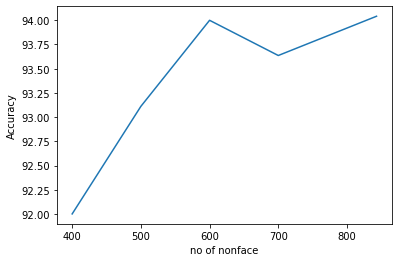

In [ ]:
numofRows=[400,500,600,700,843]
trainingData = train_data.drop(columns=['Y'])
testingData = test_data.drop(columns=['Y'])
trainingData['Y'] = 1
testingData['Y'] = 1
accuracy_last = []
for n in numofRows:
  non_faces_data = nonfaceDataValues.iloc[:n]
  train = pd.concat([trainingData, non_faces_data.iloc[::2]], ignore_index=True)
  test = pd.concat([testingData, non_faces_data.iloc[1::2]], ignore_index=True)
  accuracy_last.append(LDA(train,test,dominant))
plt.plot(numofRows, accuracy_last)
plt.xlabel('no of nonface')
plt.ylabel('Accuracy')
plt.show()

**Bouns Part**

**Change the number of 
instances per subject to be 7 and keep 3 instances per subject for testing**

In [ ]:
def splitData2(DataValues, DataMatrix):
  trainingData = []
  testingData = [] 
  training_data_labels = []
  testing_data_labels = []
  i = 0;
  while (i < 400):
    x = i
    while (x < i + 7):
      trainingData.append(DataValues.T[x])
      training_data_labels.append(DataMatrix.T[x]['Y'])
      x += 1
    while (x < i + 10):
      testingData.append(DataValues.T[x])
      testing_data_labels.append(DataMatrix.T[x]['Y'])
      x += 1
    i = x
  testingData = pd.DataFrame(testingData)
  trainingData = pd.DataFrame(trainingData)
  training_data_labels = pd.DataFrame(training_data_labels)
  testing_data_labels = pd.DataFrame(testing_data_labels)
  testingData = testingData.reset_index(drop = True)
  trainingData = trainingData.reset_index(drop = True)
  training_data_labels = training_data_labels.reset_index(drop = True)
  testing_data_labels = testing_data_labels.reset_index(drop = True)
  return trainingData, testingData, training_data_labels, testing_data_labels


In [ ]:
faces = read_dataset()
DataMatrix = getDataWithLabels(faces)
DataValues = getDataValues(faces)
trainingData, testingData, training_data_labels, testing_data_labels = splitData2(DataValues, DataMatrix)
eigenvalues, eigenvectors = getEigenValuesAndVectors(trainingData)

**Use a simple classifier (first Nearest Neighbor to determine the class labels) on the new trainingset and dataset**

accuracy matrix:  [59.5, 91.5, 97.5, 98.0, 97.5, 97.0, 96.5]
alpha:  [0.2, 0.5, 0.7, 0.8, 0.85, 0.9, 0.95]


Text(0, 0.5, 'accuracy')

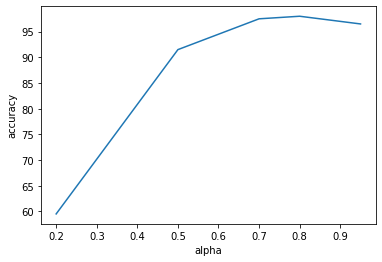

In [ ]:
alpha = [0.2,0.5,0.7,0.8, 0.85, 0.9, 0.95]
labels = []
count_mismatched = 0;
# accuracy_matrix contain accuracy for each value of alpha
accuracy_matrix = []
testing_data_labels = np.array(testing_data_labels)
training_data_labels = np.array(training_data_labels)

for alp in alpha:
  new_training_data, new_testing_data, r = PCA(trainingData, testingData, eigenvalues, eigenvectors, alp)
  for s in range (0, 120):
    query_weight = np.array(new_testing_data[s]).reshape(r, 1)
    euclidean_distance = np.linalg.norm(new_training_data - query_weight, axis=0)
    best_match = np.argmin(euclidean_distance)
    labels.append(training_data_labels[best_match])
    if (training_data_labels[best_match] != testing_data_labels[s]):
      count_mismatched +=1
    # fig, axes = plt.subplots(1,2,sharex=True,sharey=True,figsize=(8,6))
    # axes[0].imshow(np.reshape(np.ravel(testingData.T[s]), (112, 92)), cmap="gray")
    # axes[0].set_title("Query")
    # axes[1].imshow(np.reshape(np.ravel(trainingData.T[best_match]), (112, 92)), cmap="gray")
    # axes[1].set_title("Best match")
    # plt.show()
  accuracy = ((200 - count_mismatched) * 100)  / (200)
  accuracy_matrix.append(accuracy)
  count_mismatched = 0
  labels.clear()
print("accuracy matrix: ", accuracy_matrix)
print("alpha: ", alpha)
plt.plot(alpha, accuracy_matrix)
plt.xlabel("alpha")
plt.ylabel("accuracy")